# Analyzing Cultural Diversity through Census Data of Language Spoken at Home

By Jordan Crawford-O'Banner and Alli Busa

In the news, we've heard that diversity has increased in the United States. While the Census has praised the U.S. for becoming overall more racial and ethnically diverse, FOX newscaster Tucker Carlson has claimed that the rise of immigrants in the U.S. is not happening in "politicians' neighborhoods". (See Project Proposal)

We wanted to take these two clashing statements and put them both to the test. Has cultural diversity, measured through linguistic diversity, increased significantly in the past few years? How is cultural diversity, through linguistic diversity, spread out throughout the U.S.? Are regions with high ratios of non-English speakers actually linguistically diverse or homogenuously consisting of a non-English speaking community? 

## Importing Necessary Packages and Setting Up Data Imports

Importing necessary packages.

In [3]:
%matplotlib inline

#Packages for Calculating
import pandas as pd
import numpy as np
from thinkstats2 import Pmf, Cdf
import thinkstats2

#Packages for Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
import thinkplot
from IPython.display import display_html

The data that we will be analyzing for this project is the Census' processed responses to the questions,"Does this person speak a language other than English at home?" and "What is this language?". The Census is filled out by one family member for the whole household and the question has been asked as the questions in quotations above for the whole duration of our dataset. (see https://www.census.gov/topics/population/language-use/about/historical.html). 
We have three data sources from the Census: the number of speakers of over 380 languages documented for 2000, the 2006 to 2008 period and the 2009 to 2013 period. 
In each of these periods, the way that the data was has been processed into excel documents has changed. For example, in the year 2000 data, the excel spreadsheets are states and contain data on the state as a whole and its counties. These two different variables are given in the same column. On the other hand, the 2006-2008 and 2009-2013 data, the counties data and states data are given in two separate excel files altogether. 


In order to collect data from multiple Excel sheets more efficiently, we will create a list of state abbreviations and state names. This is important because the data that has been provided to us for 2006 and 2009 has separated the data for each state onto a different sheet within the excel file. We are creating two lists because some of our data's sheet names are state abbreviations and some are counties. 

In [4]:
#State abbreviations
#Taken from https://gist.github.com/JeffPaine/3083347
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
"SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

#State names
#Taken from https://gist.github.com/tleen/6299431
statesfull=['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut',
           'Delaware','Florida','Georgia',
            'Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine',
            'Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska',
            'Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota',
            'Ohio','Oklahoma','Oregon','Pennsylvania',
            'Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont',
            'Virginia','Washington','West Virginia','Wisconsin','Wyoming']

We will create a function called createSeries, which will allow us to create a Pandas Series from multiple sheets within an Excel file. 

In [5]:
def createSeries(emptySeries, arrayNames, textfileName, index, Column, skiprows=[0,1,2]):
    """
    Makes a Series with specific language information from excel file. 
    It is used for organizing data on total English speakers and total non-English speakers.
    
    It takes in the name of an empty series, into which the data goes
                arrayNames - this will be either states or statesfull, depending on how Excel sheets are organized
                textfileName - the datafile
                index - either 0 for total English speakers or 1 for total non-English speakers
                Column - depending on the year, the column which contains the number of speakers is either given as "Number of speakers" or "Number of speakers1"
                skiprows - the number of rows before the data begins changes based on Excel file. For the 2006-2008 data, it is [0,1,2], for the 2009-2013 data, it is [0,1,2,3]
                
    """
    i=0
    for area in arrayNames:

        df = pd.read_excel(textfileName, area, skiprows=skiprows).dropna()

        #dictionary[area] = df.loc[dictionaryindex1:dictionaryindex1,Column]
        emptySeries.set_value(i,df.loc[index, Column])
        
        i+=1
    
    #Clean Data
    emptySeries.replace(['(X)', '--'], np.nan, inplace=True)
    emptySeries.replace(['(B)'],0, inplace=True)
    

Note that this function also cleans the data. 
There are some entries which do not have numerical entries due to sampling error. For example, 'X' indicates that the question does not apply. 
We changed 'B' to 0, because those entries indicate that there were too few sample observations to compute an estimate, and we decided that 0 is more representative of that sampling error.

### Importing and Organizing Data

The data in the Census Excel files which we are using contains a list of languages that Americans speak at home and the corresponding number of Americans who speak each language. We have decided to start by creating Series and Dataframes of Americans who speak English at home and Americans who speak another language at home. We will refer to former group of people as EOS, 'English Only Speakers', and to the latter group of people as SONELAHs, which stands for 'Speakers of non-English languages at Home'.

First, we will create a Series of English Speakers at home and SONELAHs as well as a Dataframe for the Census data from 2000. The Census data was formatted differently, so took a different approach to processing this data. We created functions which would parse the 2000 Census data and then create CSV files from it. These functions can be found in the Parse2000 Notebook in this repository.

In [6]:
#Creating Series
eos2000 = pd.read_csv("/home/alli/The-Mother-Tongue-of-US-Communities/eng2000state.csv").iloc[0]
sonelah2000 = pd.read_csv("/home/alli/The-Mother-Tongue-of-US-Communities/other2000state.csv").iloc[0]

#Cleaning Dataset
eos2000["DC"]=  np.nan
sonelah2000["DC"]= np.nan

#Creating Dataframe
df2000=pd.DataFrame({"States": states,"EOS":eos2000[:50],"SONELAHs":sonelah2000[:50]})


Notice that we set the DC values to nan. We did this because the DC data for this file has language multiple times with no distinction, making it hard to parse. We suppose that this is because DC is separated into counties, but those counties weren't listed. In order to acommodate for this, we took DC data out of all the datasets by not including it states list.

Next, we will create the same Series and Dataframe for the 2006 data. The 2006 data is organized in multiple sheets, which are given by the state abbreviation.

In [7]:
#Creating Empty Series
eos2006=pd.Series()
sonelah2006=pd.Series()
#Referencing Textfile
txtfile2006 = "/home/alli/The-Mother-Tongue-of-US-Communities/raw_data/DetailedLanguageSpoken_State_20062008.xls"

#Creating Series
createSeries(eos2006, states, txtfile2006, 1,"Number of speakers", skiprows=[0,1,2])
createSeries(sonelah2006, states, txtfile2006, 2,"Number of speakers", skiprows=[0,1,2])

#Creating Dataframe
df2006=pd.DataFrame({"States": states,"EOS":eos2006,"SONELAHs":sonelah2006})

/home/alli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Lastly, we will create the same Series and Dataframe for the 2009 data. The 2009 data is organized in multiple sheets, which are given by the full state names. This data is also parsed differently, because the column name which belongs to the column that provides number of speakers is given as "Number of speakers1" instead of "Number of speakers". Also, in this Excel file, the parser needs to skip the first four rows, instead of the first three (initialized at 0).

In [8]:
#Creating Empty Series
eos2009=pd.Series()
sonelah2009=pd.Series()
#Referencing Textfile
txtfile2009 =  "/home/alli/The-Mother-Tongue-of-US-Communities/raw_data/LanguageSpokenatHome_State_2009-2013.xls"

#Creating Series
createSeries(eos2009, statesfull, txtfile2009, 1,"Number of speakers1", skiprows=[0,1,2,3])
createSeries(sonelah2009, statesfull, txtfile2009, 2,"Number of speakers1", skiprows=[0,1,2,3])

#Creating Dataframe
df2009=pd.DataFrame({"States": states,"EOS":eos2009,"SONELAHs":sonelah2009})

/home/alli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


## Initial Analysis - Probability Mass Functions (PMFs) 
We will begin by plotting PMFs to try to answer "Has cultural diversity, measured through linguistic diversity, increased significantly in the past few years? How is cultural diversity, through linguistic diversity, spread out throughout the U.S.? "

##### Functions
First, we will create functions which will help us analyze and graph the data. 

In [9]:
def createPMFs(df):
    """
    Takes the dataframe which contains the number of EOS and SONELAHs per census file. 
    Returns the same Dataframe with a column of PMFs of SONELAHs by state, sorted from 
    least to greatest.
    
    df - dataframe which contains the sorted number of EOS and SONELAHs per census file. ie: df2009
    """
    sonelah=df["SONELAHs"]
    eos=df["EOS"]
    df["PMF"] = sonelah/(sonelah+eos)
    df=df.sort_values(by="PMF") #sorts from least to greatest
    
    return df

In [10]:
def plotPMFs(df):
    """
    Takes the dataframe which contains the number of EOS and SONELAHs per census file. 
    Returns two graphs with PMF of only English speakers and PMF of speakers of 
    other languages as normalized percentages of total population of those states. 
    
    df - dataframe which contains the number of EOS and SONELAHs per census file. ie: df2009
    """
    dfwithPMF = createPMFs(df) #Adding a PMF column
    i =0 #begining a counter to help plot SONELAHs
    plt.figure(figsize=(20, 3)) 
    for state in dfwithPMF["PMF"]:
        plt.bar(i, state,  color='#B6D7A8')
        plt.autoscale(enable=True)
        plt.ylim([0.0,1.0])
        plt.xticks(range(0,51), dfwithPMF["States"])
        plt.title("PMF of SONELAHs by State")
        plt.xlabel("State")
        plt.ylabel("Percentage of SONELAHs")
        i+=1

In [26]:
def createTemporalTable(df2000, df2006, df2009):
    """
    Takes in the dataframes which contain the number of EOS and SONELAHs per census period.
    Returns a table that shows the top ten states with the highest percentage of SONELAHs.
    """
    
    df2000 = createPMFs(df2000) #Creates PMFs for each dataset and appends
    df2000['Percentage'] = df2000['PMF'].multiply(100.*np.ones(len(df2000['PMF']))) #Turns the PMF into a percentage
    sorteddf2000 = df2000.sort_values(by='Percentage',ascending=False) #Sorts data in order of greatest to least percentage

    df2006 = createPMFs(df2006) 
    df2006['Percentage'] = df2006['PMF'].multiply(100.*np.ones(len(df2006['PMF']))) 
    sorteddf2006 = df2006.sort_values(by='Percentage',ascending=False) 
    
    df2009 = createPMFs(df2009) 
    df2009['Percentage'] = df2009['PMF'].multiply(100.*np.ones(len(df2009['PMF']))) 
    sorteddf2009 = df2009.sort_values(by='Percentage',ascending=False) 
    
    df2000_styler = sorteddf2000.iloc[0:9,[2,4]].style.set_table_attributes("style='display:inline'").set_caption('2000').hide_index()
    df2006_styler = sorteddf2006.iloc[0:9,[2,4]].style.set_table_attributes("style='display:inline'").set_caption('2006').hide_index()
    df2009_styler = sorteddf2009.iloc[0:9,[2,4]].style.set_table_attributes("style='display:inline'").set_caption('2009').hide_index()

    display_html(df2000_styler._repr_html_()+df2006_styler._repr_html_()+df2009_styler._repr_html_(), raw=True)
    

In [27]:
def returnStatesfromRatio(df, percent, sign):
    """
    Takes in a pair of total EOS and SONELAHs, as well as desired ratio and comparison
    Returns a table with the number of states which have a percentage of SONELAHs
    which is less than or more than the percentage specified. 

    Percent - Give percent in range (0:1)
    Sign - "Less" or "More"
    """
    dfwithPMF = createPMFs(df) #Adding a PMF column

    if sign == "Less":
        result = dfwithPMF[dfwithPMF["PMF"]  < percent]
    if sign == "More":
        result = dfwithPMF[dfwithPMF["PMF"]  > percent]
        
    print(result[["States", "PMF"]])


##### Plotting 

In [28]:

createTemporalTable(df2000, df2006, df2009)

States,Percentage
DE,59.6038
CA,39.4735
NY,36.4809
UT,31.235
NC,27.9591
ID,26.6028
AZ,25.8515
NM,25.4727
GA,23.088
States,Percentage


We will plot the PMFs of SONELAHs by state per year. 

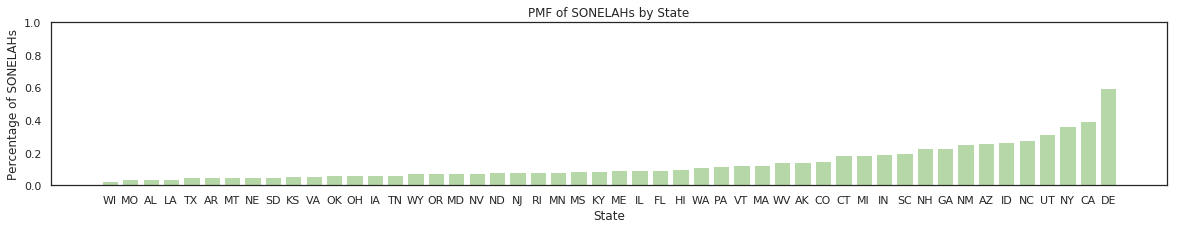

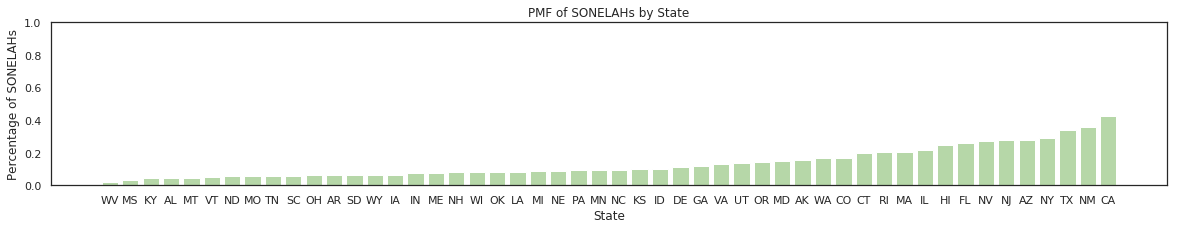

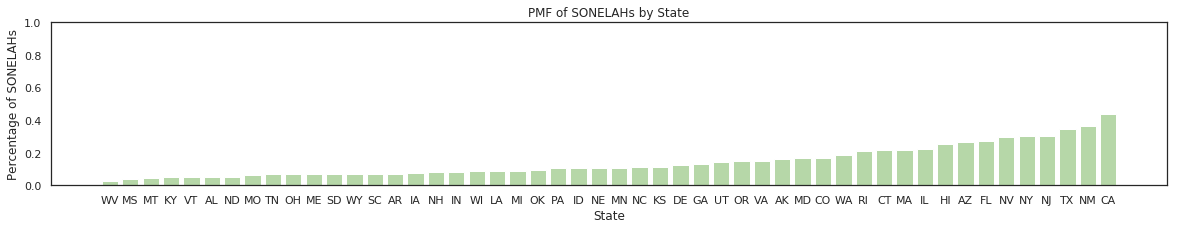

In [12]:
one = plotPMFs(df2000)
plotPMFs(df2006)
plotPMFs(df2009)

fig, (ax1,ax2) = plt.subplots(1,3, figsize=(10,4))  # 1 row, 2 columns
plotPMFs(df2006, ax=ax1)
df2.plot(..., ax=ax2)

plt.tight_layout() 

** Resolve DC
We see that throughout these three time periods, the shape of distribution and the magnitude of the percentages are relatively the same. We do see that the order of the distribution changes, however. California is first all years, but the other states shift position. New Jersey, for example, has a lower percentage of SONELAHs in the first time period, which increases in the second time period. In the last time period, New Jersey has the fourth highest percentage of SONELAHs.

Another way we can analyze the distribution of SONELAHs by state, and analyze it over time, is by comparing the tables of SONELAHs. We do that here:

First, we will show a table which contains all the states in 2006 with a percentage of SONELAHs higher than 20 %.

In [11]:
returnStatesfromRatio(df2006, 0.2, "More")

   States       PMF
38     RI  0.203898
20     MA  0.204680
12     IL  0.216818
10     HI  0.248403
8      FL  0.257681
27     NV  0.273154
29     NJ  0.276368
2      AZ  0.278547
31     NY  0.288556
42     TX  0.336948
30     NM  0.358435
4      CA  0.423500
